<a href="https://colab.research.google.com/github/Dharuneswar/Review_classification/blob/main/RestaurentReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk wordcloud wget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import wget
import gzip
import nltk
nltk.download('punkt', force=True)
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU,
                                     GlobalMaxPooling1D, Conv1D, Dropout,
                                     Bidirectional, Flatten)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
filename = 'cc.en.300.vec.gz'
if not os.path.exists(filename):
    wget.download(url)

In [ ]:
embeddings_index = {}
with gzip.open(filename, 'rt', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/green_leaf_veg_restaurent_reviews.csv')
print(df)
df = df[['Review']].drop_duplicates()

                Restaurant Name  \
0     Green Leaf Veg Restaurant   
1     Green Leaf Veg Restaurant   
2     Green Leaf Veg Restaurant   
3     Green Leaf Veg Restaurant   
4     Green Leaf Veg Restaurant   
...                         ...   
9994  Green Leaf Veg Restaurant   
9995  Green Leaf Veg Restaurant   
9996  Green Leaf Veg Restaurant   
9997  Green Leaf Veg Restaurant   
9998  Green Leaf Veg Restaurant   

                                                 Review  
0     I have bought several of the Vitality canned d...  
1     Product arrived labeled as Jumbo Salted Peanut...  
2     This is a confection that has been around a fe...  
3     If you are looking for the secret ingredient i...  
4     Great taffy at a great price.  There was a wid...  
...                                                 ...  
9994  I switched from Similac Advanced to Organic wh...  
9995  we switched from the advance similac to the or...  
9996  Like the bad reviews say, the organic formula ...  

In [ ]:
positive_words = [
    'great', 'good', 'amazing', 'nice', 'love', 'excellent', 'best', 'tasty', 'delicious',
    'fresh', 'friendly', 'fantastic', 'perfect', 'wonderful', 'clean', 'affordable',
    'quick', 'fast', 'neat', 'awesome', 'pleasant', 'yummy', 'hygienic', 'enjoyed',
    'satisfying', 'healthy', 'impressive', 'crispy', 'flavorful', 'soft', 'rich',
    'spicy', 'authentic', 'polite', 'homely', 'variety', 'value', 'well-prepared',
    'hot', 'warm', 'cozy', 'attentive', 'smiling', 'helpful', 'delightful', 'fantabulous',
    'great service', 'decent', 'highly recommend', 'superb', 'finger-licking', 'amazing taste',
    'freshly made', 'lovely', 'welcoming', 'excellent service', 'piping hot', 'good portion',
    'perfectly cooked', 'balanced flavor', 'delectable', 'fine dining', 'clean environment','super'
]

negative_words = [
    'bad', 'worst', 'terrible', 'awful', 'disgusting', 'poor', 'hate', 'cold', 'rude',
    'dirty', 'unfriendly', 'slow', 'overpriced', 'bland', 'burnt', 'delay', 'spoiled',
    'unclean', 'raw', 'stale', 'hard', 'soggy', 'greasy', 'costly', 'dry', 'noisy',
    'unhygienic', 'waiting', 'unpleasant', 'overcooked', 'undercooked', 'horrible',
    'tasteless', 'bad smell', 'not fresh', 'bad service', 'unprofessional', 'careless',
    'forgot order', 'late service', 'unappetizing', 'cold food', 'no taste', 'too salty',
    'too spicy', 'overcooked', 'noisy place', 'unclean plates', 'unfriendly staff',
    'low quality', 'rushed service', 'uncomfortable', 'rude staff', 'bad experience','bland', 'soggy', 'greasy', 'burnt', 'cold', 'dry', 'undercooked', 'overcooked', 'stale', 'raw',
    'tasteless', 'watery', 'rubbery', 'salty', 'too spicy', 'too sweet', 'flavorless', 'mushy',
    'hard', 'bitter', 'slow service', 'rude staff', 'unfriendly', 'inattentive', 'unprofessional',
    'careless', 'forgot order', 'wrong order', 'no apology', 'delayed', 'dismissive', 'rushed',
    'ignored', "didn't check on us", 'bad attitude', 'manager problem', 'long wait', 'messed up bill',
    'confused staff', 'no greeting', 'dirty', 'unclean', 'unhygienic', 'filthy', 'sticky tables',
    'smelly', 'bugs', 'hair in food', 'stained plates', 'messy floor', 'bad smell', 'unsanitary',
    'moldy', 'grimy', 'gross', 'noisy', 'crowded', 'uncomfortable seating', 'bad lighting', 'too dark',
    'loud music', 'hot inside', 'cold inside', 'chaotic', 'boring decor', 'cramped', 'stuffy', 'dusty',
    'overpriced', 'expensive', 'not worth it', 'poor value', 'hidden charges', 'small portions',
    'costly', 'overcharged', 'bad deal', 'waste of money', 'disappointing', 'regret going',
    'not impressed', 'horrible experience', 'never again', 'worst ever', 'not fresh', 'low quality',
    'unpleasant', 'bad experience', 'unacceptable', 'lack of flavor', 'terrible service',
    'flavorless food', 'cold dish', 'bad food'
]

# ✅ Sentiment labeling
def label_sentiment(text):
    text = str(text).lower()
    pos = sum(word in text for word in positive_words)
    neg = sum(word in text for word in negative_words)
    if neg > pos:
        return 0
    elif pos > neg:
        return 1
    else:
        return 2

df['Sentiment'] = df['Review'].apply(label_sentiment)

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer

tokenizer_nltk = RegexpTokenizer(r'\w+')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\d+', '', text)
    tokens = tokenizer_nltk.tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)


df['Cleaned_Review'] = df['Review'].apply(clean_text)

In [ ]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Review'])
sequences = tokenizer.texts_to_sequences(df['Cleaned_Review'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

In [ ]:
word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index) + 1)
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment'])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
def build_dense_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def build_cnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
        Conv1D(128, 5, activation='relu'),
        Dropout(0.3),
        Conv1D(64, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
def build_bilstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def train_and_evaluate(model, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(
        X_train, y_train,
        epochs=20,  # ✅ Increased from 10
        batch_size=64,  # ✅ Increased from 32
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stop, checkpoint],  # ✅ Added callbacks
        verbose=1
    )

    print(f"\nEvaluating {model_name}...")
    loss, acc = model.evaluate(X_test, y_test)
    print(f"{model_name} Test Accuracy: {acc:.4f}")

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()



Training Dense Neural Network...
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3338 - loss: 1.0945

96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.3337 - loss: 1.0946 - val_accuracy: 0.2293 - val_loss: 1.1077
Epoch 2/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4143 - loss: 0.9876

96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.4153 - loss: 0.9877 - val_accuracy: 0.7017 - val_loss: 0.8532
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6547 - loss: 0.7702 - val_accuracy: 0.6531 - val_loss: 0.8293
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7554 - loss: 0.5726 - val_accuracy: 0.6932 - val_loss: 0.7692
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8443 - loss: 0.4082 - val_accuracy: 0.6978 - val_loss: 0.7965
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8855 - loss: 0.3097 - val_accuracy: 0.6656 - val_loss: 0.8789
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9092 - loss: 0.2258 - val_accuracy: 0.6899 - val_loss: 0.9296

Evaluating Dense Neural Network...
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6506 - loss: 0.8225
Dense Neural Network Test Accuracy: 0.6674
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

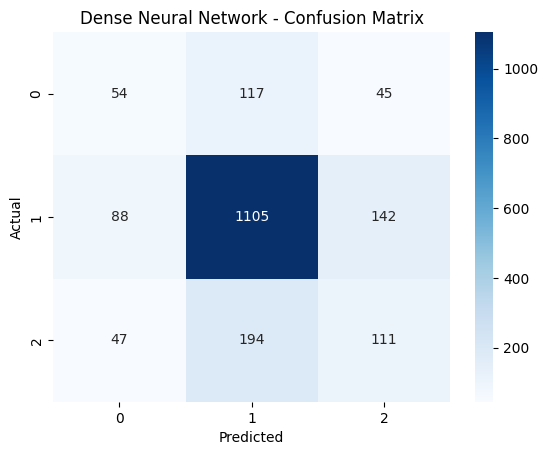

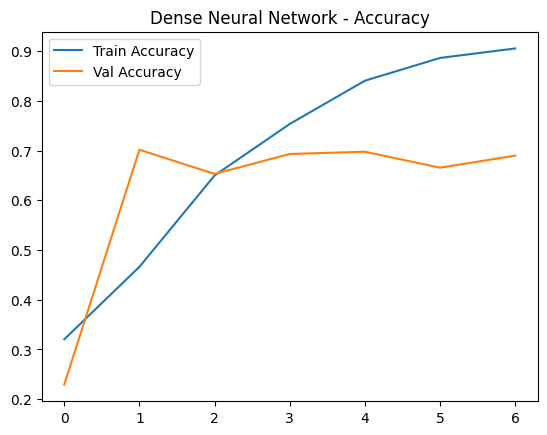

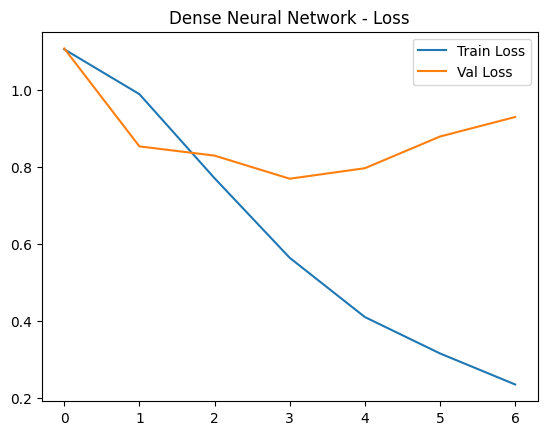

In [ ]:
train_and_evaluate(build_dense_model(), "Dense Neural Network")


Training 1D CNN Model...
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.2831 - loss: 1.1268 - val_accuracy: 0.6873 - val_loss: 0.9136
Epoch 2/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5960 - loss: 0.9614

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.5961 - loss: 0.9609 - val_accuracy: 0.7418 - val_loss: 0.6959
Epoch 3/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6958 - loss: 0.8161

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6957 - loss: 0.8160 - val_accuracy: 0.7608 - val_loss: 0.6412
Epoch 4/20
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7401 - loss: 0.7072

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.7399 - loss: 0.7073 - val_accuracy: 0.7845 - val_loss: 0.5884
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.7466 - loss: 0.7028 - val_accuracy: 0.7733 - val_loss: 0.5456
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.7810 - loss: 0.5590 - val_accuracy: 0.7602 - val_loss: 0.6400
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.8149 - loss: 0.5088 - val_accuracy: 0.7398 - val_loss: 0.6979
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.8284 - loss: 0.4154 - val_accuracy: 0.7260 - val_loss: 0.7303

Evaluating 1D CNN Model...
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7585 - loss: 0.5875
1D CNN Model Test Accuracy: 0.7630
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
              precision    recall  f1-score   support

           0       0.59      0.41      0.48       216
           1       0.89      0.85      0.87      1335
           2       0.47   

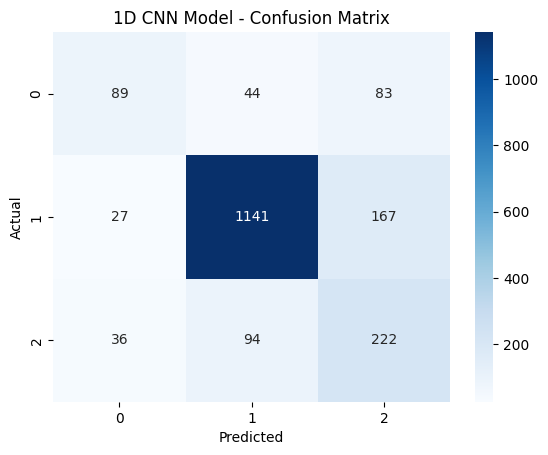

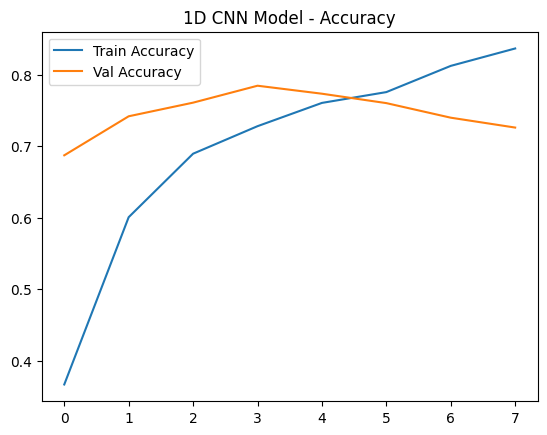

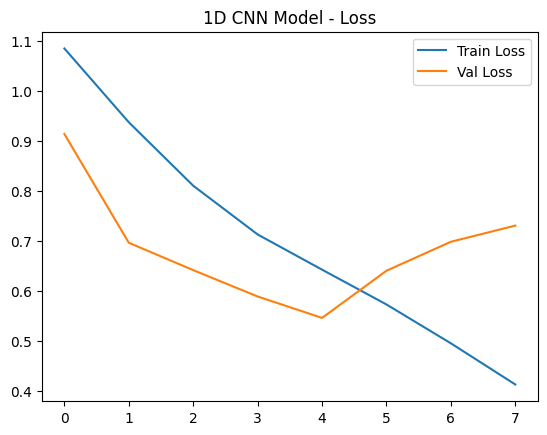

In [ ]:
train_and_evaluate(build_cnn_model(), "1D CNN Model")


Training Bidirectional LSTM...
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.3415 - loss: 1.1033 - val_accuracy: 0.6603 - val_loss: 0.8393
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.5669 - loss: 0.9590 - val_accuracy: 0.6097 - val_loss: 0.8372
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 375ms/step - accuracy: 0.6238 - loss: 0.8960 - val_accuracy: 0.4691 - val_loss: 1.0284
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 402ms/step - accuracy: 0.6251 - loss: 0.9128 - val_accuracy: 0.7030 - val_loss: 0.6893
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.6828 - loss: 0.8021 - val_accuracy: 0.7306 - val_loss: 0.6503
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.6886 - loss: 0.7861 - val_accuracy: 0.7188 - val_loss: 0.6648
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.7007 - loss: 0.7581 - val_accuracy: 0.6735 - val_loss: 0.7620
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 

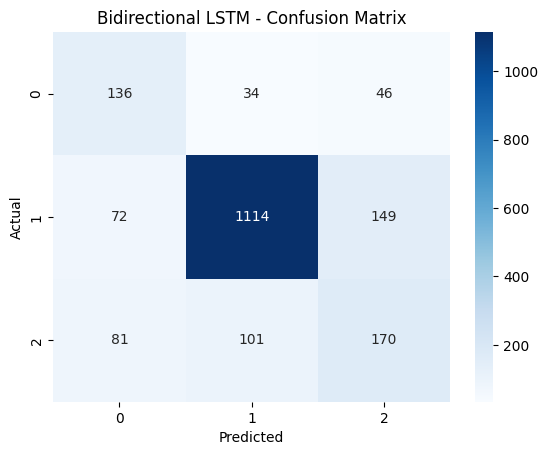

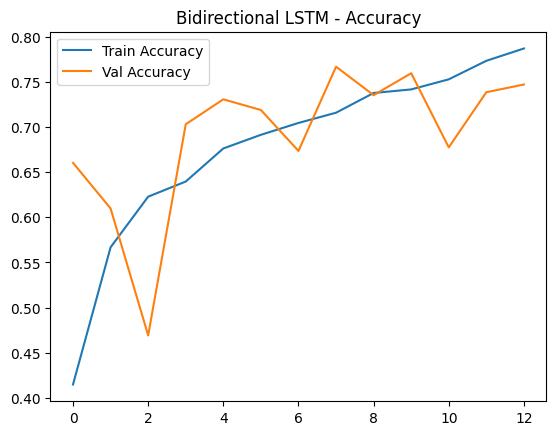

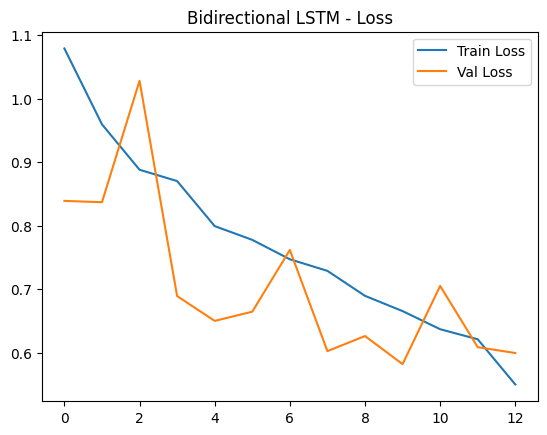

In [ ]:
train_and_evaluate(build_bilstm_model(), "Bidirectional LSTM")

In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Load the best weights saved during training
best_model = load_model('best_model.h5')


In [ ]:
import pickle

# Let's say 'best_model' is your trained model object
with open('food_review_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("✅ Model saved as food_review_model.pkl")


✅ Model saved as food_review_model.pkl


In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved as 'tokenizer.pkl'")


✅ Tokenizer saved as 'tokenizer.pkl'


In [ ]:
def predict_sentiment(review):
    # Clean and preprocess the input review
    cleaned_review = clean_text(review)

    # Tokenize and pad the cleaned review
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Predict sentiment using the loaded model
    prediction = best_model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction, axis=1)[0]

    # Map sentiment score to label
    if sentiment_score == 0:
        return "Negative"
    elif sentiment_score == 1:
        return "Positive"
    else:
        return "Neutral"

In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Load the best weights saved during training
# The `best_model.h5` file contains the entire model, including architecture and weights
best_model = load_model('best_model.h5')

# Save the model using pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Best model saved to best_model.pkl")

Best model saved to best_model.pkl


In [ ]:
user_review = "This restaurant has amazing food and friendly staff!"
predicted_sentiment = predict_sentiment(user_review)
print(f"The sentiment of the review '{user_review}' is: {predicted_sentiment}")

user_review_2 = "The service was slow and the food was cold."
predicted_sentiment_2 = predict_sentiment(user_review_2)
print(f"The sentiment of the review '{user_review_2}' is: {predicted_sentiment_2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
The sentiment of the review 'This restaurant has amazing food and friendly staff!' is: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The sentiment of the review 'The service was slow and the food was cold.' is: Negative


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
    loaded_model = load_model('best_model.h5')
    print("Model loaded successfully from best_model.h5")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_model.h5' exists and is a valid Keras model file.")
    loaded_model = None #

Model loaded successfully from best_model.h5


In [ ]:
 if loaded_model:
    user_input_review = input("Enter the review you want to analyze: ")


    cleaned_review = clean_text(user_input_review)

    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    prediction = loaded_model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction, axis=1)[0]

    if sentiment_score == 0:
        predicted_sentiment = "Negative"
    elif sentiment_score == 1:
        predicted_sentiment = "Positive"
    else:
        predicted_sentiment = "Neutral"

    print(f"The sentiment of the review '{user_input_review}' is: {predicted_sentiment}")
else:
    print("Model was not loaded successfully, cannot perform prediction.")

Enter the review you want to analyze: good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
The sentiment of the review 'good' is: Neutral


In [ ]:
!pip -q install gradio

import pickle, numpy as np, gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

with open("best_model.pkl", "rb") as f:
    model = pickle.load(f)
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
try:
    with open("max_len.pkl", "rb") as f:
        MAX_LEN = pickle.load(f)
except FileNotFoundError:
    MAX_LEN = 100

label_map = {0: "Negative", 1: "Positive", 2: "Neutral"}

def predict_fn(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    probs = model.predict(padded, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    return label_map[pred_idx], {
        "Negative": float(probs[0]),
        "Positive": float(probs[1]),
        "Neutral":  float(probs[2]),
    }

demo = gr.Interface(
    fn=predict_fn,
    inputs=gr.Textbox(lines=5, placeholder="Type a food review..."),
    outputs=[gr.Label(num_top_classes=1), gr.JSON()],
    title="Food Review Sentiment (BiLSTM)",
    description="Enter a restaurant review to get the predicted sentiment.",
    examples=[
        ["This restaurant has amazing food and friendly staff!"],
        ["The service was slow and the food was cold."],
        ["It was okay, nothing special."]
    ],
)

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://980598c8aa4fe4a5d1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
